# Data Science Academy - Projeto 04
# Prevendo Customer Churn em Operadoras de Telecom

Customer Churn (ou Rotatividade de Clientes, em uma tradução livre)
refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento
comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a
rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de
fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da
receita. Portanto, é muito importante prever os usuários que provavelmente
abandonarão o relacionamento comercial e os fatores que afetam as decisões do
cliente.

Neste projeto, criei um modelo de Machine Learning para prever o Customer Churn em uma Operadora de Telecom.

In [1]:
# Importando pacotes
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# Lendo os arquivos csv de treino e teste
df_treino = pd.read_csv("projeto4_telecom_treino.csv", index_col=0) 
df_teste = pd.read_csv("projeto4_telecom_teste.csv",index_col=0)

# Visualizando as primeiras linhas
df_treino.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [3]:
# Verificando quantas linhas/colunas do conjunto de dados
print("Treino " + str(df_treino.shape))
print("Teste " + str(df_teste.shape))

Treino (3333, 20)
Teste (1667, 20)


In [4]:
# Verificando se possui campos vazios (NaN)
df_treino.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [5]:
# Sumário de estatisticas
df_treino.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [6]:
# Analisando a classificação da variável target (Churn)
df = pd.DataFrame(df_treino.churn.value_counts())
df['Porcentagem'] = 100*df['churn']/df_treino.shape[0]
df

,churn,Porcentagem
no,2850,85.508551
yes,483,14.491449


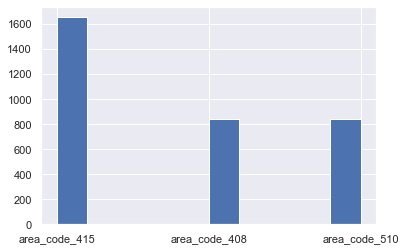

In [7]:
# Quantidade de ocorrências(frequência) por area code
df_treino['area_code'].hist()

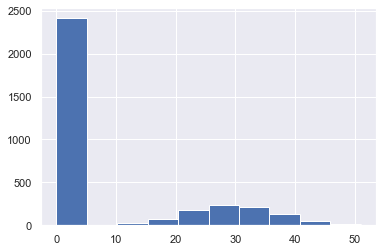

In [8]:
# Quantidade de ocorrências(frequência) por numero de v_mail messages
df_treino['number_vmail_messages'].hist()

In [9]:
# Análise de churn por área code
df_treino.groupby(['area_code','churn']).size()

area_code      churn
area_code_408  no        716
               yes       122
area_code_415  no       1419
               yes       236
area_code_510  no        715
               yes       125
dtype: int64

In [10]:
## Criando colunas com as médias do período do dia para cada variável: total minutos, ligações e cobrança
## É realizado um cálculo aritmético das colunas do tempo (day/eve/night) para cada variável relacionada

# Dados de treino
df_treino['media_minutos_dia'] = (df_treino['total_day_minutes']+df_treino['total_eve_minutes']+
                                  df_treino['total_night_minutes'])/3

df_treino['media_ligacoes_dia'] = (df_treino['total_day_calls']+df_treino['total_eve_calls']+
                                  df_treino['total_night_minutes'])/3

df_treino['media_cobranca_dia'] = (df_treino['total_day_charge']+df_treino['total_eve_charge']+
                                  df_treino['total_night_charge'])/3

# Dados de teste
df_teste['media_minutos_dia'] = (df_teste['total_day_minutes']+df_teste['total_eve_minutes']+
                                  df_teste['total_night_minutes'])/3

df_teste['media_ligacoes_dia'] = (df_teste['total_day_calls']+df_teste['total_eve_calls']+
                                  df_teste['total_night_minutes'])/3

df_teste['media_cobranca_dia'] = (df_teste['total_day_charge']+df_teste['total_eve_charge']+
                                  df_teste['total_night_charge'])/3

# Saída
df_treino.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,media_minutos_dia,media_ligacoes_dia,media_cobranca_dia
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,no,235.733333,151.233333,24.286667
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,no,203.833333,160.133333,18.513333
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,no,175.733333,128.866667,19.666667
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,no,186.066667,118.633333,21.673333
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,no,167.300000,140.633333,16.453333


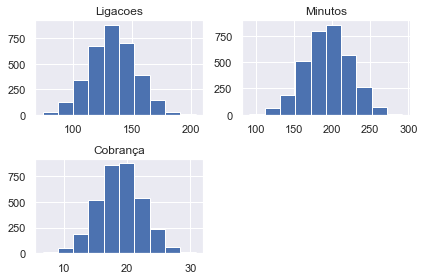

In [11]:
# Frequencias entre medias criadas - Ligacoes/minutos/cobrança

plt.subplot(2,2,1) # Configuração (2x2) e posição (1) do gráfico no plot.
df_treino['media_ligacoes_dia'].hist() # Tipo de gráfico 
plt.title('Ligacoes') # Título do gráfico
plt.subplot(2,2,2)
df_treino['media_minutos_dia'].hist()
plt.title('Minutos')
plt.subplot(2,2,3)
df_treino['media_cobranca_dia'].hist()
plt.title('Cobrança')
plt.tight_layout() # Ajuste dos títulos na configuração do desenho


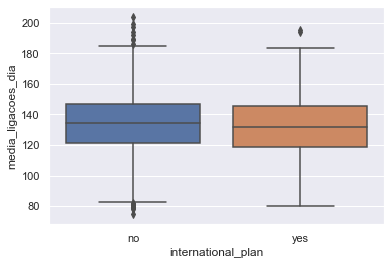

In [12]:
# Análise media ligacoes com plano internacional
sns.boxplot(x="international_plan", y="media_ligacoes_dia", data=df_treino)

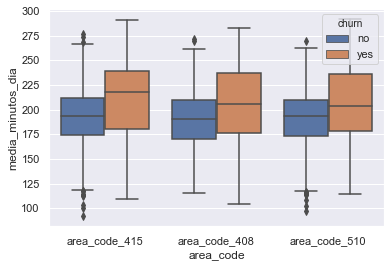

In [13]:
# Análise media total minutos por cód. area e churn 
sns.boxplot(x="area_code", y="media_minutos_dia", hue="churn", data=df_treino)

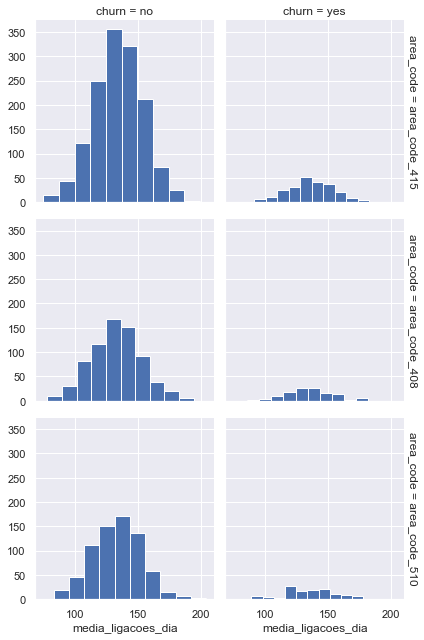

In [14]:
# Análise media ligacoes por cód. area e churn 
g = sns.FacetGrid(df_treino, row="area_code", col="churn", margin_titles=True) # Montagem do 'esqueleto'
g.map(plt.hist, "media_ligacoes_dia") # Aplicando map() para preenchimento do conteúdo em cada plot

Text(0.5, 1.03, 'Correlação entre as médias de ligações/total minutos/cobrança')

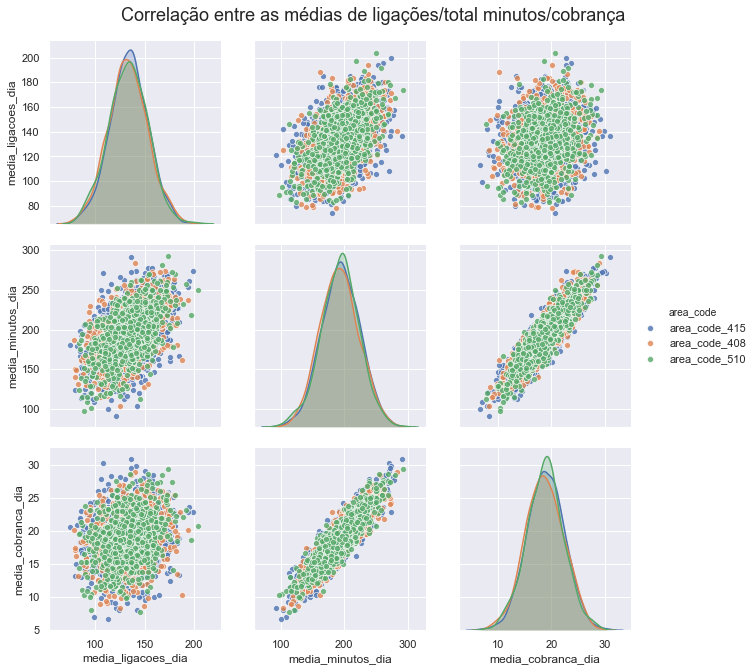

In [15]:
# Scatter plot entre colunas de medias para verificar correlação
sns.pairplot(df_treino, vars = ["media_ligacoes_dia", "media_minutos_dia", "media_cobranca_dia"], hue="area_code", 
            plot_kws= {'alpha': 0.8}, size=3)

# Título do gráfico
plt.suptitle('Correlação entre as médias de ligações/total minutos/cobrança', 
             size = 18, y=1.03)

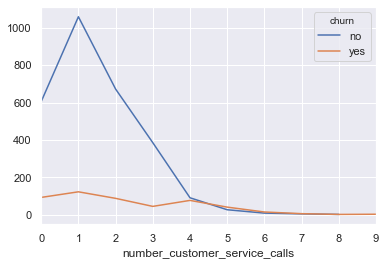

In [16]:
## Credit for this post by SIMONE CENTELLEGHER
# https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html

# Visualizando relação de nr. de ligações de serviço ao cliente com a quantidade de churn.
df_treino.groupby(['number_customer_service_calls','churn']).count()['account_length'].unstack().plot()

In [17]:
# Binarização de variáveis categóricas

## Convertendo os valores das variáveis para binários (yes = 0 / no = 1)
# Dados treino
df_treino['international_plan'] = df_treino['international_plan'].map(lambda x: 0 if x == 'yes' else 1)
df_treino['voice_mail_plan'] = df_treino['voice_mail_plan'].map(lambda x: 0 if x == 'yes' else 1)
df_treino['churn'] = df_treino['churn'].map(lambda x: 0 if x == 'yes' else 1)

# Dados teste
df_teste['international_plan'] = df_teste['international_plan'].map(lambda x: 0 if x == 'yes' else 1)
df_teste['voice_mail_plan'] = df_teste['voice_mail_plan'].map(lambda x: 0 if x == 'yes' else 1)
df_teste['churn'] = df_teste['churn'].map(lambda x: 0 if x == 'yes' else 1)

# Saída
df_treino.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,media_minutos_dia,media_ligacoes_dia,media_cobranca_dia
1,KS,128,area_code_415,1,0,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,1,235.733333,151.233333,24.286667
2,OH,107,area_code_415,1,0,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,1,203.833333,160.133333,18.513333
3,NJ,137,area_code_415,1,1,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,1,175.733333,128.866667,19.666667
4,OH,84,area_code_408,0,1,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,1,186.066667,118.633333,21.673333
5,OK,75,area_code_415,0,1,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,1,167.300000,140.633333,16.453333


In [18]:
# Feature selection - Método Ensemble Bagged Decision Tree

# Retirando variáveis não numéricas
X_treino = df_treino.drop(labels= ["churn", "area_code", "state"], axis=1)
Y_treino = df_treino["churn"]
X_teste = df_teste.drop(labels= ["churn"], axis=1)
Y_teste = df_teste["churn"]

# Criação do Modelo para verificar a importância das variáveis
modeloFS = ExtraTreesClassifier()
modeloFS.fit(X_treino, Y_treino)

# Print dos Resultados
print(X_treino.columns)
print(modeloFS.feature_importances_)

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls',
       'media_minutos_dia', 'media_ligacoes_dia', 'media_cobranca_dia'],
      dtype='object')
[0.02794828 0.07448382 0.02821247 0.02279381 0.08003108 0.02882837
 0.08383354 0.03477118 0.02625114 0.03621644 0.02787043 0.02687524
 0.02760846 0.0364171  0.04467861 0.03868135 0.12515898 0.07663524
 0.02675597 0.1259485 ]


In [19]:
## Selecionando as variáveis e criando subset para usar no modelo preditivo
# Dados treino
df_treino_reduzido = df_treino[['international_plan','number_customer_service_calls','media_minutos_dia',
                       'media_ligacoes_dia','media_cobranca_dia']]

# Dados teste
df_teste_reduzido = df_teste[['international_plan','number_customer_service_calls','media_minutos_dia',
                       'media_ligacoes_dia','media_cobranca_dia']]

In [20]:
## Criação do modelo - Regressão logistica

# Definindo o número de folds para Cross Validation
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando um pipeline para balancear a classe TARGET com o método SMOTE dentro do Cross-Validation
imba_pipeline = make_pipeline(SMOTE(random_state=42),LogisticRegression())
    
# Cross Validation
resultadoLR = cross_val_score(imba_pipeline, df_treino_reduzido, Y_treino, cv = kfold, scoring = 'accuracy')

# Imprimindo resultado da média das acurácias do CV 
print("Acurácia: %.3f" % (resultadoLR.mean() * 100))

Acurácia: 78.096


In [21]:
## Criação de um novo modelo - XGboost

# Definindo o número de folds para Cross Validation
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Modelo XGBoost
modeloXGB = XGBClassifier()

# Criando um pipeline para balancear a classe TARGET com o método SMOTE dentro do Cross-Validation
imba_pipeline = make_pipeline(SMOTE(random_state=42),modeloXGB)
    
# Cross Validation
resultadoXGB = cross_val_score(imba_pipeline, df_treino_reduzido, Y_treino, cv = kfold, scoring = 'accuracy')

# Imprimindo resultado da média das acurácias do CV 
print("Acurácia: %.3f" % (resultadoXGB.mean() * 100))

Acurácia: 89.199


Por conta da melhor acurácia no Cross validation, o algoritmo a ser utilizado será o XGBoost. 

In [22]:
## Treinando o modelo preditivo e fazendo previsões

# Treinando o modelo pelo XGBoost
modeloXGB.fit(df_treino_reduzido, Y_treino)
# Realizando as previsões
y_pred = modeloXGB.predict(df_teste_reduzido)
# Capturando os valores
previsoes = [round(value) for value in y_pred]

# Avaliando as previsões com confusion matrix e métrica da acurácia
matrix = confusion_matrix(Y_teste, previsoes)
print(matrix)
accuracy = accuracy_score(Y_teste, previsoes)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

[[ 122  102]
 [  45 1398]]
Acurácia: 91.18%


In [23]:
## Preparando submission 

# Criando dataframe final com colunas 'ID' e 'churn'(previsões)
df_resultado = pd.DataFrame(previsoes, columns = ['churn'])
df_resultado['ID'] = np.arange(1,1668)
print(df_resultado)

# Salvando resultado
df_resultado.to_csv("resultado_final.csv", index=False)

      churn    ID
0         1     1
1         1     2
2         0     3
3         1     4
4         1     5
...     ...   ...
1662      1  1663
1663      1  1664
1664      1  1665
1665      1  1666
1666      1  1667

[1667 rows x 2 columns]
